In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
    import tensorflow as tf
    from tensorflow.keras import layers

    class DynamicTanh(layers.Layer):
        def __init__(self, **kwargs):
            super(DynamicTanh, self).__init__(**kwargs)
        
        def build(self, input_shape):
            # Learnable scaling parameter alpha (initialized to 1)
            self.alpha = self.add_weight(
                name="alpha",
                shape=(1,),
                initializer=tf.keras.initializers.Ones(),
                trainable=True
            )
            # Learnable offset parameter beta (initialized to 0)
            self.beta = self.add_weight(
                name="beta",
                shape=(1,),
                initializer=tf.keras.initializers.Zeros(),
                trainable=True
            )
            super(DynamicTanh, self).build(input_shape)
        
        def call(self, inputs):
            return tf.math.tanh(self.alpha * inputs + self.beta)




In [62]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

# Define a simple dynamic tanh activation layer.
class DynamicTanh(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.tanh(inputs)

class CustomMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, alpha=1.0, **kwargs):
        """
        Custom multi-head attention with integrated pairwise delta R bias.

        d_model: Model dimension.
        num_heads: Number of attention heads.
        alpha: Scale factor for the pairwise mask.
        """
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.alpha = alpha

    def build(self, input_shape):
        # Create weight matrices for Q, K, and V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = tf.keras.layers.Dense(self.d_model)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth) and then transpose.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x, raw_input=None, return_attention=False):
        """
        x: Tensor of shape (batch, seq_len, d_model) -- the embedded inputs.
        raw_input: Tensor of shape (batch, seq_len, 3) -- the original [pt, eta, phi],
                   used to compute the pairwise mask (not used in this simplified example).
        return_attention: If True, also return the attention weights.
        """
        batch_size = tf.shape(x)[0]

        # Linear projections for Q, K, V.
        q = tf.matmul(x, self.wq)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into multiple heads.
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Compute scaled dot-product attention logits.
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Softmax to get attention weights.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # Compute the attention output.
        scaled_attention = tf.matmul(attention_weights, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        if return_attention:
            return output, attention_weights
        else:
            return output

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, alpha=1.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.mha = CustomMultiHeadAttention(d_model, num_heads, alpha=alpha)
        # Replace dynamic tanh with layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])

    def call(self, x, return_attention=False):
        if return_attention:
            attn_output, attn_weights = self.mha(x, return_attention=True)
        else:
            attn_output = self.mha(x, return_attention=False)
        # Apply residual connection followed by layer normalization.
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        if return_attention:
            return out2, attn_weights
        else:
            return out2



class AggregationLayer(tf.keras.layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Aggregation not implemented. Use 'mean' or 'max'.")

def build_custom_transformer_classifier(num_particles, feature_dim,
                                        d_model=8, d_ff=8, output_dim=8,
                                        num_heads=8, alpha=1.0, return_attention=False):
    """
    Build a classifier model with:
      - A linear embedding layer.
      - A transformer block with integrated pairwise computations.
      - Aggregation over the sequence dimension.
      - A final classification layer.
    
    return_attention: If True, the model will output a tuple 
                      (classification_output, attention_matrix)
    """
    inputs = tf.keras.layers.Input(shape=(num_particles, feature_dim))
    
    # Linear embedding.
    x = tf.keras.layers.Dense(d_model, activation='relu')(inputs)
    
    # Transformer block.
    if return_attention:
        x, attn_weights = TransformerBlock(d_model, d_ff, output_dim=d_model,
                                             num_heads=num_heads, alpha=alpha)(x, return_attention=True)
    else:
        x = TransformerBlock(d_model, d_ff, output_dim=d_model,
                               num_heads=num_heads, alpha=alpha)(x)
    
    # Aggregate over the sequence (particle) dimension.
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    # Final dense layers for classification.
    x = tf.keras.layers.Dense(16, activation='relu')(pooled_output)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    if return_attention:
        model = tf.keras.models.Model(inputs=inputs, outputs=[outputs, attn_weights])
    else:
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

# Example instantiation with attention output enabled:
num_particles = 32
feature_dim = 3  # [pt, eta, phi]
model = build_custom_transformer_classifier(
    num_particles=num_particles,
    feature_dim=feature_dim,
    d_model=16,
    d_ff=16,
    output_dim=16,
    num_heads=4,
    alpha=1.0,
    return_attention=True
)
model.summary()
#model.load_weights('noPairs32.weights.h5')
# Example usage:


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_14            │ [(None, 32, 16),       │         1,648 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_14            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069 (8.08 KB)

 Trainable params: 2,069 (8.08 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from sklearn.model_selection import train_test_split


In [22]:
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# Perform an 80/20 split on the original training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)


In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.load_weights('noPairs32.weights.h5')

model.summary()





Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_13            │ (None, 32, 16)         │         1,648 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_13            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069 (8.08 KB)

 Trainable params: 2,069 (8.08 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model = build_custom_transformer_classifier(
    num_particles=num_particles,
    feature_dim=feature_dim,
    d_model=16,
    d_ff=16,
    output_dim=16,
    num_heads=4,
    alpha=1.0,
    return_attention=False
)
model.load_weights('1layerTransformerLayer.weights.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=250, 
    batch_size=1024
)


Epoch 1/250


2025-04-02 18:04:18.775814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


485/485 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7645 - loss: 0.6673 - val_accuracy: 0.7674 - val_loss: 0.6614
Epoch 2/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7683 - loss: 0.6585 - val_accuracy: 0.7684 - val_loss: 0.6589
Epoch 3/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7692 - loss: 0.6572 - val_accuracy: 0.7697 - val_loss: 0.6570
Epoch 4/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7695 - loss: 0.6569 - val_accuracy: 0.7679 - val_loss: 0.6596
Epoch 5/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7700 - loss: 0.6553 - val_accuracy: 0.7617 - val_loss: 0.6722
Epoch 6/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7693 - loss: 0.6573 - val_accuracy: 0.7707 - val_loss: 0.6534
Epoch 7/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7707 - loss: 0.6536 - val_accuracy: 0.7583 - val_loss: 0.6801
Epoch 8/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7711 - loss: 0.6522 - val_

KeyboardInterrupt: 

In [71]:
model = build_custom_transformer_classifier(
    num_particles=num_particles,
    feature_dim=feature_dim,
    d_model=16,
    d_ff=16,
    output_dim=16,
    num_heads=4,
    alpha=1.0,
    return_attention=True
)

In [72]:
model.load_weights('1layerTransformerLayer.weights.h5')

In [70]:
model.save_weights('1layerTransformerLayer.weights.h5')

In [73]:
output, attention = model(x_val[0].reshape(1,32,3))

In [74]:
import matplotlib.pyplot as plt

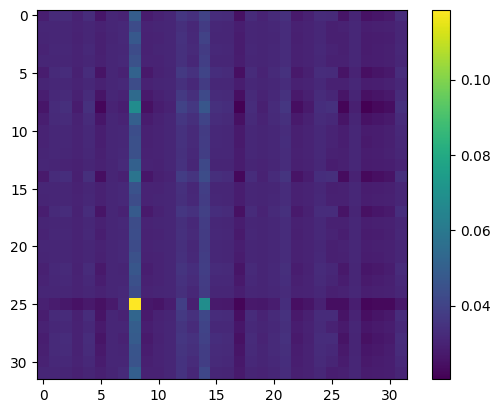

In [75]:
plt.imshow(attention[0][3])
plt.colorbar()

In [13]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops


input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
import numpy as np
import time

_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



2025-03-27 14:34:26.794227: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-03-27 14:34:26.794287: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-27 14:34:26.794631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-27 14:34:26.794643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference:
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Pl

In [10]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_32const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_32const_ptetaphi.npy")

In [11]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 260000) + inhomogeneous part.

In [34]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.7698961538461538

In [35]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

1/FPR at TPR=80% for each class:
g: 1/FPR = 7.950214460784314
q: 1/FPR = 7.315039798910767
W: 1/FPR = 28.015776699029125
Z: 1/FPR = 32.807139472437214
t: 1/FPR = 20.53718189919794
Average 1/FPR across classes: 19.32507046607187

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8593
q: accuracy = 0.8510
W: accuracy = 0.9313
Z: accuracy = 0.9354
t: accuracy = 0.9207
Average accuracy across classes: 0.8995


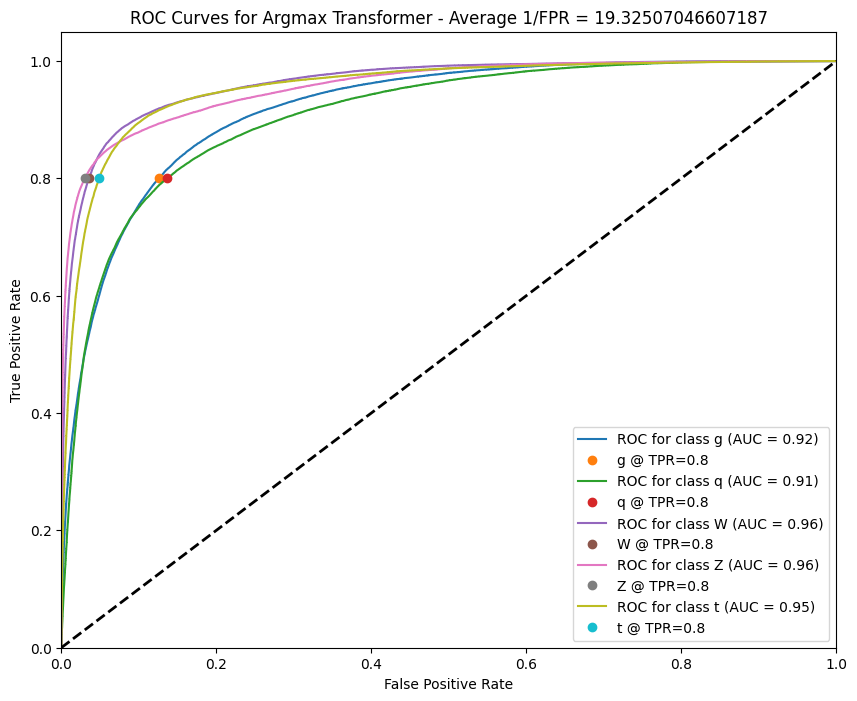

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()



In [380]:
def superpositionMLP(superposition, weight, bias = np.zeros(16)):

    output = np.einsum('bij,ik->bkj', superposition, weight)

    output[:, :,3] += bias

    return output

def superPositionRelu(superposition):
    # Compute the sum of activations along each neuron's dimension.
    total_activations = np.sum(superposition, axis=2)
    
    # Zero out rows (neurons) with non-positive total activations.
    superposition[total_activations < 0] = 0
    return superposition

In [381]:
def superpositionMLP2D(superposition, weight, bias):
    
    output = np.einsum('ij,ik->kj', superposition, weight)
    
    output[:, 3] += bias
    return output

def superPositionRelu2D(superposition):
    # Compute the sum of activations along each neuron's dimension.
    total_activations = np.sum(superposition, axis=1)
    
    # Zero out rows (neurons) with non-positive total activations.
    superposition[total_activations < 0] = 0
    return superposition

In [449]:
model.compile()

In [382]:
jet = 0

In [408]:
superposition = np.zeros((32, 3, 4))
num = 0
for x in x_val[jet]:
    index = 0
    for feature in range(3):

        superposition[num, index, index] = x[index]

        index = index + 1
    num = num + 1

In [425]:
superposition = np.zeros((32, 3, 32*3+1))
num = 0
count = 0 
for x in x_val[jet]:
    index = 0
    for feature in range(3):

        superposition[num, index, count] = x[index]

        index = index + 1
        count = count + 1
    num = num + 1

In [491]:
def superpositionRec(x_val,model, jet):
    superposition = np.zeros((32, 3, 4))
    num = 0
    for x in x_val[jet]:
        index = 0
        for feature in range(3):

            superposition[num, index, index] = x[index]

            index = index + 1
        num = num + 1
    superposition=superpositionMLP(superposition, model.variables[0].numpy(), model.variables[1].numpy())
    superposition = superPositionRelu(superposition)
    superposition=superpositionMLP(superposition, model.variables[4].numpy(), np.zeros(16))
    output, attention = model(np.reshape(x_val[jet],[1,32,3]))
    superposition = superposition.reshape(4,32,4,4)
    attn_output = np.einsum('ijk, ikmn-> ikmn', attention.numpy()[0], superposition)
    superposition = np.concatenate(superposition, axis=1)
    attn_output = np.concatenate(attn_output, axis=1)
    tanhOut = np.tanh(superposition + attn_output)


    superposition = superpositionMLP(tanhOut, model.variables[7].numpy(), model.variables[8].numpy())
    superposition = superPositionRelu(tanhOut)

    superposition = superpositionMLP(tanhOut, model.variables[9].numpy(), model.variables[10].numpy())
    superposition = np.tanh(superposition + tanhOut)
    superposition = tf.reduce_max(superposition, axis=0).numpy()
    superposition = superpositionMLP2D(superposition, model.variables[11].numpy(), model.variables[12].numpy())
    superposition = superPositionRelu2D(superposition)
    superposition = superpositionMLP2D(superposition, model.variables[13].numpy(), model.variables[14].numpy())
    return superposition, output

In [492]:
from tqdm import tqdm

In [493]:
x_val.shape

(260000, 32, 3)

In [490]:
accuracyTrue = []
accuracyModel = []
logits = []
outputs = []
superpositions = []
for jet in tqdm(range(100)):
    logit, output = superpositionRec(x_val, model, jet)
    logits.append(logit)
    outputs.append(output.numpy())
    

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 2048 into shape (4,32,8,4)

In [485]:
np.argmax(np.sum(logits, axis=2), axis=1)

array([4, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1,
       4, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 4, 1, 4, 4, 1, 4, 1, 1, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 1,
       1, 1, 4, 1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 4, 4, 4, 4, 1, 4, 1, 1, 1, 1, 1])

In [486]:
np.argmax(outputs, axis=2).squeeze()

array([4, 0, 4, 2, 3, 4, 1, 3, 1, 3, 1, 0, 3, 0, 2, 0, 1, 1, 4, 1, 3, 2,
       0, 0, 3, 3, 4, 2, 2, 3, 3, 2, 4, 4, 3, 2, 0, 1, 1, 2, 2, 4, 0, 1,
       2, 4, 3, 0, 2, 1, 3, 4, 1, 2, 4, 1, 2, 0, 3, 4, 4, 3, 1, 1, 0, 0,
       4, 2, 1, 0, 4, 4, 2, 0, 2, 3, 2, 4, 2, 1, 0, 0, 0, 0, 2, 2, 2, 4,
       0, 0, 0, 1, 4, 3, 2, 4, 3, 2, 4, 4])

In [404]:
np.argmax(outputs,axis=2)

array([[4]])

In [90]:
import numpy as np

def softmax(x):
    # Subtract max for numerical stability
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)



In [146]:
np.argmax(softmax(logits))

4

In [147]:
softmax(logits)

array([4.35783482e-03, 3.44727543e-01, 4.26051585e-08, 1.16141270e-09,
       6.50914578e-01])

In [149]:
np.argmax(output.numpy())

4

In [150]:
softmax(logits)

array([4.35783482e-03, 3.44727543e-01, 4.26051585e-08, 1.16141270e-09,
       6.50914578e-01])

In [151]:
output.numpy()

array([[1.4666139e-01, 8.2516171e-02, 7.2101236e-04, 6.7074987e-04,
        7.6943064e-01]], dtype=float32)

In [506]:
accuracyTrue = []
accuracyModel = []
logits_all = []
outputs_all = []
superpositions_all = []

for jet in tqdm(range(100)):
    logit, output = superpositionRec(x_val, model, jet)
    logits_all.append(logit)
    outputs_all.append(output.numpy())

100%|██████████| 100/100 [00:01<00:00, 75.26it/s]


In [509]:
logits_all[0]

array([ 0.11838642,  0.15610892, -0.04378782, -0.14612642, -0.0244713 ],
      dtype=float32)

In [507]:
np.argmax(np.sum(logits_all,axis=2), axis=1)

AxisError: axis 2 is out of bounds for array of dimension 2

In [504]:
np.argmax(outputs_all, axis=2).squeeze()

array([4, 0, 4, 2, 3, 4, 1, 3, 1, 3, 1, 0, 3, 0, 2, 0, 1, 1, 4, 1, 3, 2,
       0, 0, 3, 3, 4, 2, 2, 3, 3, 2, 4, 4, 3, 2, 0, 1, 1, 2, 2, 4, 0, 1,
       2, 4, 3, 0, 2, 1, 3, 4, 1, 2, 4, 1, 2, 0, 3, 4, 4, 3, 1, 1, 0, 0,
       4, 2, 1, 0, 4, 4, 2, 0, 2, 3, 2, 4, 2, 1, 0, 0, 0, 0, 2, 2, 2, 4,
       0, 0, 0, 1, 4, 3, 2, 4, 3, 2, 4, 4])

In [516]:
import tensorflow as tf
import numpy as np

# Function to compute the gradient of the target logit w.r.t. the input features.
def compute_gradients(input_sample, target_class=0):
    """
    Computes the gradient of the target logit with respect to the input features.

    Args:
      input_sample: A tensor of shape (batch_size, 32, 3) representing the input.
      target_class: The index of the output class for which to compute the gradient.

    Returns:
      gradients: Tensor of shape (batch_size, 32, 3) with the gradients.
      target_logit: The scalar logit value for the target class.
    """
    input_sample = tf.convert_to_tensor(input_sample)
    with tf.GradientTape() as tape:
        tape.watch(input_sample)
        logits, _ = model(input_sample, training=False)
        target_logit = logits[:, target_class]  # (batch_size,)
    gradients = tape.gradient(target_logit, input_sample)
    return gradients, target_logit

# Function to print the local linear (closed-form) approximation for a single sample.
def print_closed_form(input_sample, target_class=0):
    """
    For a single input sample, prints a closed-form (local linear) approximation of the logit.
    The approximation is:
        logit ≈ baseline_logit + Σ_{i=1}^{32} [a_i * pt_i + b_i * eta_i + c_i * phi_i]
    where the coefficients (a_i, b_i, c_i) are the gradients.
    """
    # Ensure we work with a batch of size 1.
    assert input_sample.shape[0] == 1, "Input sample batch size must be 1."
    
    # Compute gradients at the given input.
    grads, logit_val = compute_gradients(input_sample, target_class)
    grads = grads.numpy()[0]  # shape (32, 3)
    logit_val = logit_val.numpy()[0]
    
    # Compute baseline logit (using a baseline input, e.g., zeros)
    baseline_input = np.zeros_like(input_sample)
    baseline_logit = model(baseline_input, training=False)[0].numpy()[0, target_class]
    
    # The local linear approximation is:
    # logit ≈ baseline_logit + sum_{particle=1}^{32} sum_{feature in [pt, eta, phi]} (gradient * feature)
    print(f"Baseline logit (with zero input): {baseline_logit:.4f}")
    print("Local linear approximation for the target logit (first class):")
    
    total_contribution = baseline_logit
    for i in range(32):
        pt_coef = grads[i, 0]
        eta_coef = grads[i, 1]
        phi_coef = grads[i, 2]
        pt_val = input_sample[0, i, 0]
        eta_val = input_sample[0, i, 1]
        phi_val = input_sample[0, i, 2]
        
        contribution = pt_coef * pt_val + eta_coef * eta_val + phi_coef * phi_val
        total_contribution += contribution
        
        print(f"  Particle {i+1}: {pt_coef:.4f}*pt{i+1} + {eta_coef:.4f}*eta{i+1} + {phi_coef:.4f}*phi{i+1}")
    
    print(f"\nLocal linear approximation of logit for class {target_class}: {total_contribution:.4f}")
    print(f"Actual logit from model: {logit_val:.4f}")

# Example usage:
# Create a dummy input: a single sample with 32 particles, each having 3 features.
dummy_input = x_val[0].reshape(1, 32, 3).astype(np.float32)
print_closed_form(dummy_input, target_class=0)

Baseline logit (with zero input): 0.7313
Local linear approximation for the target logit (first class):
  Particle 1: -0.1479*pt1 + -0.3190*eta1 + -0.1628*phi1
  Particle 2: 0.0587*pt2 + -0.0403*eta2 + -0.0449*phi2
  Particle 3: 0.0538*pt3 + -0.0313*eta3 + -0.0180*phi3
  Particle 4: 0.0478*pt4 + -0.0326*eta4 + -0.0397*phi4
  Particle 5: 0.0485*pt5 + -0.0303*eta5 + -0.0161*phi5
  Particle 6: -0.0734*pt6 + 0.0829*eta6 + 0.0547*phi6
  Particle 7: -0.1155*pt7 + -0.0629*eta7 + 0.0254*phi7
  Particle 8: 0.0031*pt8 + -0.0487*eta8 + -0.0126*phi8
  Particle 9: 0.0102*pt9 + -0.0448*eta9 + -0.0125*phi9
  Particle 10: 0.0265*pt10 + -0.0234*eta10 + -0.0241*phi10
  Particle 11: 0.0306*pt11 + 0.0022*eta11 + -0.0105*phi11
  Particle 12: -0.0951*pt12 + -0.0505*eta12 + 0.0267*phi12
  Particle 13: -0.1801*pt13 + 0.0576*eta13 + 0.0303*phi13
  Particle 14: 0.0392*pt14 + -0.0204*eta14 + -0.0239*phi14
  Particle 15: 0.0347*pt15 + -0.0200*eta15 + -0.0375*phi15
  Particle 16: -0.1187*pt16 + 0.0439*eta16 + 0.02

In [518]:
output[0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.04026346, 0.19299054, 0.00737291, 0.03776041, 0.72161263],
      dtype=float32)>

In [519]:
import tensorflow as tf
import numpy as np

# --- Utility: a simple LRP rule for a dense layer (epsilon-rule) ---
def lrp_dense(x, dense_layer, R_out, epsilon=1e-6):
    """
    Propagate relevance R_out from a Dense layer back to its input x.
    
    Args:
      x: Input tensor to the dense layer, shape (batch, in_features)
      dense_layer: a tf.keras.layers.Dense instance.
      R_out: Relevance at the output of the dense layer, shape (batch, out_features)
      epsilon: small number for stability.
      
    Returns:
      R_in: Relevance distributed to x, shape (batch, in_features)
    """
    # Get weights and bias
    W = dense_layer.kernel  # shape (in_features, out_features)
    b = dense_layer.bias    # shape (out_features,)
    
    # Forward pass: compute the pre-activation contributions.
    Z = tf.matmul(x, W) + b  # shape (batch, out_features)
    # Stabilize denominator
    Z_stable = Z + epsilon * tf.where(tf.greater_equal(Z, 0), 1.0, -1.0)
    
    # Contribution from each input: shape (batch, in_features, out_features)
    # We use broadcasting: (batch, in_features)[:, :, None] * (W[None, :, :]) gives shape (batch, in_features, out_features)
    contribution = (x[:, :, None] * W[None, :, :]) / Z_stable[:, None, :]
    
    # Propagate relevance: sum over outputs to get relevance for each input feature.
    R_in = tf.reduce_sum(contribution * R_out[:, None, :], axis=-1)
    return R_in

# --- Utility: LRP rule for layer normalization ---
def lrp_layer_norm(x, gamma, beta, R_out, epsilon=1e-6):
    """
    Propagate relevance through a layer normalization.
    Layer normalization computes:
      y = gamma * ((x - mean)/sqrt(var+epsilon)) + beta
    Because normalization couples all inputs, one common approach is to distribute
    relevance proportionally to the contribution of each input.
    
    This is a non-trivial step and several variants exist.
    Here we assume a simple proportional rule.
    
    Args:
      x: Input tensor of shape (batch, features)
      gamma: Scale parameter, shape (features,)
      beta: Offset parameter, shape (features,)
      R_out: Relevance at the output, same shape as x.
      
    Returns:
      R_in: Relevance for x, same shape as x.
    """
    # Compute normalized x (as in the forward pass)
    mean, variance = tf.nn.moments(x, axes=[-1], keepdims=True)
    std = tf.sqrt(variance + epsilon)
    x_norm = (x - mean) / std
    # The effective linear contribution of each x_i is given by gamma / std.
    weights = gamma / std  # shape (batch, features) after broadcasting gamma
    # Distribute R_out in proportion to the absolute contribution.
    # (This is one possible rule; LRP for layer norm is an area of active research.)
    contrib = tf.abs(x * weights)
    contrib_sum = tf.reduce_sum(contrib, axis=-1, keepdims=True) + epsilon
    R_in = (contrib / contrib_sum) * R_out
    return R_in

# --- Utility: LRP rule for the attention layer ---
def lrp_attention(x, mha_layer, R_out, input_activation):
    """
    Propagate relevance through the multi-head attention.
    We assume that the attention layer computes:
      Q = x W_q, K = x W_k, V = x W_v,
      then attention weights A = softmax(QK^T / sqrt(d_k)),
      and output = A * V, then a final Dense projection.
      
    We assume that we can treat the attention as coefficients on the value vectors.
    Moreover, if V is linear in x (i.e. V = x W_v), then we can backpropagate R_out
    exactly as a linear combination.
    
    Args:
      x: Input to the attention block, shape (batch, seq_len, d_model)
      mha_layer: the custom multi-head attention layer.
      R_out: Relevance at the output of the attention block, shape (batch, seq_len, d_model)
      input_activation: The original activation that went into the attention block.
      
    Returns:
      R_in: Relevance attributed back to x.
    """
    # For simplicity, we assume the mha_layer exposes its attention weights and
    # the projection matrices.
    # (You would need to modify your custom attention layer to store these during the forward pass.)
    
    # Get the attention weights A and the value projection W_v:
    A = mha_layer.attention_weights  # shape (batch, num_heads, seq_len, seq_len)
    W_v = mha_layer.wv  # shape (d_model, d_model)
    
    # Get the value vectors: V = x @ W_v, then split into heads, etc.
    V = tf.matmul(input_activation, W_v)  # shape (batch, seq_len, d_model)
    
    # For each head, the contribution from the j-th input to the i-th output is A[i,j] * V[j]
    # For an exact decomposition, we “pull back” the relevance R_out (after the final dense projection of attention)
    # onto the value vectors, and then back to the original x via the linear transformation W_v.
    # This example uses a simplified rule:
    
    # First, average the attention over heads:
    A_mean = tf.reduce_mean(A, axis=1)  # shape (batch, seq_len, seq_len)
    
    # Now, distribute relevance from each output token back to each input token proportionally to A_mean.
    # Assume R_out is of shape (batch, seq_len, d_model) and V is of shape (batch, seq_len, d_model).
    # We “reverse” the multiplication by W_v:
    # Compute contribution factors from V back to x:
    # (This is analogous to a dense layer; you can use a similar rule as in lrp_dense.)
    
    # First, propagate relevance from the attention output to V:
    R_V = tf.matmul(tf.transpose(A_mean, perm=[0,2,1]), R_out)  # shape (batch, seq_len, d_model)
    
    # Now, propagate relevance from V to x using the dense rule.
    # Reshape x and R_V to 2D.
    batch, seq_len, d_model = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
    x_flat = tf.reshape(x, (batch * seq_len, d_model))
    R_V_flat = tf.reshape(R_V, (batch * seq_len, d_model))
    # Use the dense LRP rule with W_v.
    R_in_flat = lrp_dense(x_flat, dense_layer=tf.keras.layers.Dense(d_model, use_bias=False,
                                                                     kernel_initializer=tf.constant_initializer(W_v.numpy())),
                          R_out=R_V_flat)
    R_in = tf.reshape(R_in_flat, (batch, seq_len, d_model))
    return R_in

# --- Example: Exact decomposition through a simplified transformer classifier ---
#
# Suppose we have a model with the following structure:
#  1. Embedding: Dense layer with ReLU.
#  2. Transformer block: Multi-head attention (with layernorm and residual) followed by a feedforward (dense, ReLU, dense)
#     with layernorm.
#  3. Aggregation: e.g. max pooling over the sequence dimension.
#  4. Classification: Two Dense layers (last with no nonlinearity to get logits).
#
# To decompose the logit for each class exactly, you would do a forward pass and store the intermediate activations.
# Then, starting from the output logit for class c, you would backpropagate “relevance” using the above rules.
#
# Below is a schematic outline. (Note: this is a skeleton – you will need to adjust it to your actual model.)

def exact_decomposition(model, input_sample, target_class):
    """
    Compute an exact decomposition of the logit for target_class in terms of the input features.
    
    Returns a tensor of shape (1, 32, 3) representing the exact contribution of each feature.
    """
    # Forward pass: store intermediate activations.
    # You need to modify your model (or use a modified forward function) to capture:
    # - The embedding output.
    # - The output of the multi-head attention (and its stored attention weights).
    # - The outputs after each layer norm.
    # - The aggregated (pooled) representation.
    # - The final dense layers.
    
    # For illustration, let’s assume we have functions that perform the forward pass and return a dictionary:
    activations = model.forward_with_activations(input_sample)
    # activations might be a dict with keys:
    # 'emb': embedding output, shape (1, 32, d_model)
    # 'attn': output of multi-head attention (before layernorm)
    # 'ln1': output after first layer norm (i.e. emb + attn)
    # 'ffn': output of feed-forward network
    # 'ln2': output after second layer norm (i.e. ln1 + ffn)
    # 'pool': aggregated representation, shape (1, d_model)
    # 'dense1': output after first final dense (with ReLU)
    # 'logits': final logits, shape (1, num_classes)
    
    # Also assume the multi-head attention layer stored its attention weights in:
    # activations['attn_weights']
    
    # Now start with the target logit for class target_class.
    logits = activations['logits']  # shape (1, num_classes)
    # We set relevance R at the output to be all zeros except for the target class.
    R = tf.zeros_like(logits)
    R = tf.tensor_scatter_nd_update(R, [[0, target_class]], [logits[0, target_class]])
    
    # --- Backpropagate through the final Dense layer (dense2) ---
    # Let dense2 be the final dense layer (without activation) that maps from dense1 to logits.
    dense2 = model.get_layer('dense_2')  # adjust layer name accordingly
    dense1_out = activations['dense1']  # shape (1, hidden_dim)
    R_dense1 = lrp_dense(dense1_out, dense2, R)  # relevance for dense1 output
    
    # --- Backpropagate through the first final Dense (dense1) ---
    dense1 = model.get_layer('dense_1')  # adjust name accordingly
    pooled = activations['pool']  # shape (1, d_model)
    R_pool = lrp_dense(pooled, dense1, R_dense1)
    
    # --- Backpropagate through the aggregation layer ---
    # If using max pooling, the relevance is attributed to the input token(s) that achieved the maximum.
    # For simplicity, assume we know which token index was selected.
    # (In practice, you’d need to record the argmax from the forward pass.)
    pooled_index = activations.get('pool_index', 0)  # index of the token selected
    R_ln2 = tf.zeros_like(activations['ln2'])  # shape (1, seq_len, d_model)
    R_ln2 = tf.tensor_scatter_nd_update(R_ln2, [[0, pooled_index]], [R_pool[0]])
    
    # --- Backpropagate through the transformer block ---
    # Decompose through the feed-forward network and the residual+layernorm.
    # Here we would use lrp_dense for the feed-forward dense layers and lrp_layer_norm for the layernorms.
    # For brevity, let’s assume we have a function that does the full transformer block:
    R_ln1 = propagate_through_transformer_block(activations, R_ln2)
    # (You would implement propagate_through_transformer_block using the rules above for dense, attention,
    # and layer normalization.)
    
    # --- Backpropagate through the embedding layer ---
    emb = activations['emb']  # shape (1, 32, d_model)
    # Suppose the embedding was produced by a Dense layer with ReLU from the original input.
    embedding_dense = model.get_layer('embedding_dense')  # adjust name accordingly
    # Reshape the input sample to match the dense layer’s expectation if necessary.
    input_flat = tf.reshape(input_sample, (1, -1))  # shape (1, 32*3)
    emb_flat = tf.reshape(emb, (1, -1))             # shape (1, 32*d_model)
    R_input_flat = lrp_dense(input_flat, embedding_dense, tf.reshape(R_ln1, (1, -1)))
    R_input = tf.reshape(R_input_flat, (1, 32, 3))
    
    return R_input

# --- Example usage ---
# Assume you have modified your transformer classifier to use layernorm and to expose
# a forward_with_activations method.
dummy_input = np.random.rand(1, 32, 3).astype(np.float32)
target_class = 0  # for example, decompose the logit for class 0

# Compute the exact decomposition.
R_input = exact_decomposition(model, dummy_input, target_class)
print("Exact contribution of each feature for class", target_class)
print(R_input.numpy())


AttributeError: 'Functional' object has no attribute 'forward_with_activations'

In [78]:
import tensorflow as tf
import numpy as np

# Assume 'model' is your pretrained transformer classifier that outputs [logits, attn_weights]
# Here, we create a function to compute gradients of the logits with respect to the inputs.
def compute_input_gradients(model, input_data):
    """
    Compute the gradient of the output logits with respect to the input_data.
    
    Args:
      model: The pretrained transformer model.
      input_data: A tensor of shape (batch_size, 32, 3).
      
    Returns:
      logits: The model's output logits (before softmax) or probabilities if that's what the model outputs.
      gradients: The gradients of the logits with respect to the input data.
    """
    # Ensure we record the operations on the input_data.
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        # Forward pass. If your model returns attention as well, we extract the logits.
        logits, _ = model(input_data, training=False)
    
    # Compute the gradient of the logits with respect to the input.
    gradients = tape.gradient(logits, input_data)
    return logits, gradients

# Create a dummy input for one event with shape (1, 32, 3)
dummy_input = tf.convert_to_tensor(x_val[0].reshape(1, 32, 3))

# Compute the logits and the gradients.
logits, input_grads = compute_input_gradients(model, dummy_input)

print("Logits:")
print(logits.numpy())
print("\nInput gradients shape:", input_grads.shape)


Logits:
[[0.45055163 0.36576945 0.07713236 0.08931856 0.01722811]]

Input gradients shape: (1, 32, 3)


In [83]:
input_grads

<tf.Tensor: shape=(1, 32, 3), dtype=float64, numpy=
array([[[-3.62904089e-08,  5.84024384e-09, -9.60354818e-09],
        [-5.41380913e-08, -1.40403600e-09, -8.02353739e-09],
        [-6.77299852e-08,  3.29617933e-09, -2.16623022e-08],
        [-5.97878369e-08, -4.88332752e-09, -9.33749700e-09],
        [-6.84285908e-08, -1.24130040e-09, -1.41802019e-08],
        [-8.77411253e-07, -1.30474902e-08,  1.06704725e-08],
        [-6.10114483e-08, -4.70746997e-10, -1.31426265e-08],
        [ 1.55262470e-10, -1.70631420e-08, -1.39995162e-08],
        [ 1.30568128e-06,  6.30958965e-08,  2.29937470e-07],
        [-2.91977926e-08,  9.21671361e-09, -1.57129261e-08],
        [-5.59940787e-08, -7.66238628e-10, -1.20976908e-08],
        [-8.50848920e-08,  6.28507379e-09, -1.70311090e-08],
        [-3.62767381e-08,  5.08600806e-08, -1.11225766e-08],
        [-7.53170184e-08,  6.49683614e-08, -1.60761346e-07],
        [ 1.46889420e-07,  2.94015345e-09,  4.82790803e-08],
        [-6.77644891e-08, -6.7015

In [95]:
from tqdm import tqdm

In [ ]:
import tensorflow as tf
import numpy as np
logitsPred = []
output = []
#jacobians = []

# Assume your pretrained transformer model is already defined and loaded as `model`
# and that it outputs a tuple: (logits, attention_weights).

# Create a dummy input representing one event: (batch=1, 32 particles, 3 features)
for jet in tqdm(range(100)):
    dummy_input = tf.convert_to_tensor(x_val[jet].reshape(1,32,3))

    with tf.GradientTape() as tape:
        tape.watch(dummy_input)
        logits, attn_weights = model(dummy_input, training=False)

    # Compute the Jacobian: shape expected is (batch, num_classes, 1, 32, 3)
    jacobian = tape.jacobian(logits, dummy_input)

    # Squeeze the extra dimension (of size 1) to get shape: (1, num_classes, 32, 3)
    jacobian = tf.squeeze(jacobian, axis=2)

    # Optionally, reconstruct the logits using a linear approximation:
    # Here we assume a baseline of zeros.
    baseline = tf.zeros_like(dummy_input)
    # The einsum computes the weighted sum: (batch, num_classes)
    linear_component = tf.einsum('bckf,bkf->bc', jacobian, dummy_input - baseline)

    logitsPred.append(softmax(linear_component))
    output.append(logits)



  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [106]:
a = np.argmax(logitsPred, axis=2).squeeze()

In [107]:
b = np.argmax(output, axis=2).squeeze()

In [109]:
import sklearn

In [110]:
sklearn.metrics.accuracy_score(a, b)

0.48

In [164]:
# Compute logits and the local linear mapping (Jacobian) for the given input.
outputs = []
logits = []
dummy_input = tf.convert_to_tensor(x_val[0].reshape(1,32,3).astype('float32'))


# Assume your pretrained transformer classifier is defined as `model`
# and that it outputs a tuple: (logits, attention_weights)
# For example, you might have built it with:
# model = build_custom_transformer_classifier(..., return_attention=True)

# Create a dummy input representing one event: (batch=1, 32 particles, 3 features)

# Run the model and compute the Jacobian for the effective linear mapping.
with tf.GradientTape() as tape:
    tape.watch(dummy_input)
    logits, attn_weights = model(dummy_input, training=False)

# Compute softmax of the model's logits for reference.
model_softmax = tf.nn.softmax(logits, axis=-1)

# Compute the Jacobian of the logits with respect to the input.
jacobian = tape.jacobian(logits, dummy_input)
# Remove the extra singleton dimension: resulting shape (1, num_classes, 32, 3)
jacobian = tf.squeeze(jacobian, axis=2)

# Compute the effective linear contribution from the input features.
linear_component = tf.einsum('bckf,bkf->bc', jacobian, dummy_input)

# Compute the effective bias: difference between the model's logits and the linear contribution.
effective_bias = logits - linear_component

# Compute effective logits as the sum of the linear component and the bias.
effective_logits = linear_component + effective_bias

# Compute the softmax from the effective logits.
effective_softmax = tf.nn.softmax(effective_logits, axis=-1)

# Print model outputs and the effective softmax computed via the Jacobian.
print("Model logits:")
print(logits.numpy())

print("\nModel softmax probabilities:")
print(model_softmax.numpy())

print("\nEffective logits computed from Jacobian (should equal model logits):")
print(effective_logits.numpy())

print("\nSoftmax computed from effective logits:")
print(effective_softmax.numpy())



Model logits:
[[0.45055163 0.36576945 0.07713236 0.08931856 0.01722811]]

Model softmax probabilities:
[[0.25302008 0.23245265 0.17417306 0.17630856 0.16404572]]

Effective logits computed from Jacobian (should equal model logits):
[[0.45055163 0.3657695  0.07713236 0.08931857 0.01722811]]

Softmax computed from effective logits:
[[0.25302005 0.23245265 0.17417306 0.17630854 0.16404572]]


In [171]:
np.round(jacobian[0][2],4)

array([[-0.1377,  0.0047, -0.0093],
       [-0.1109,  0.0019,  0.0009],
       [-0.1409, -0.0062, -0.0021],
       [-0.11  , -0.0059, -0.0066],
       [-0.1351, -0.0025,  0.0033],
       [-3.2332, -0.0446,  0.0815],
       [-0.1149, -0.0029, -0.0099],
       [-0.3021, -0.1276, -0.0237],
       [ 1.0044,  0.0743,  0.2667],
       [-0.1294,  0.0089, -0.0121],
       [-0.105 , -0.002 , -0.0093],
       [-0.1957,  0.0064, -0.0149],
       [-0.0944,  0.0472, -0.0087],
       [-0.1962, -0.0295,  0.0021],
       [ 0.039 ,  0.0015,  0.0456],
       [-0.1344, -0.0022,  0.0021],
       [-0.1586, -0.0006,  0.0156],
       [-0.1685, -0.0043, -0.0009],
       [-0.1543,  0.    ,  0.0151],
       [-0.1064, -0.0011, -0.0103],
       [-0.0957, -0.0018,  0.001 ],
       [-0.1002,  0.0272, -0.0296],
       [-0.1841,  0.0016, -0.0082],
       [-0.191 ,  0.0025, -0.0109],
       [-0.1539, -0.0036, -0.0193],
       [-0.1172,  0.029 , -0.0073],
       [ 0.158 ,  0.0356,  0.0606],
       [-0.129 ,  0.0107, -0

In [173]:
np.sum(jacobian[0][0],axis=1)

array([ 0.83829784,  0.47283515,  0.5828725 ,  0.48969528,  0.5135601 ,
       13.809104  ,  0.5150374 ,  3.3417737 , -0.7455582 ,  0.8148373 ,
        0.47786295,  0.89946914,  0.43380016,  0.68199885,  0.57857025,
        0.5142268 ,  0.5803656 ,  0.8666091 ,  0.5707764 ,  0.48477906,
        0.41292584,  0.49746943,  0.9544153 ,  0.86352897,  0.7394105 ,
        0.3244051 ,  1.2282172 ,  0.7912624 ,  0.8728798 ,  0.7590487 ,
       -0.14036167,  0.6560653 ], dtype=float32)

In [163]:
np.set_printoptions(suppress=True)

np.round(jacobian[0][0],4)

array([[ 0.0983,  0.0423,  0.1632],
       [ 0.1271, -0.0097,  0.0165],
       [ 0.0982,  0.026 , -0.0165],
       [ 0.0835,  0.0026,  0.0093],
       [ 0.1386, -0.0177,  0.0217],
       [ 0.1473, -0.0093,  0.0284],
       [ 0.1096, -0.0241,  0.0082],
       [ 0.1036, -0.0039, -0.0107],
       [ 0.1055,  0.0115, -0.0151],
       [ 0.1453, -0.    ,  0.0105],
       [ 0.0834,  0.0027,  0.0088],
       [ 0.1132,  0.0034,  0.0149],
       [ 0.224 ,  0.281 , -0.0764],
       [ 0.0889, -0.0256, -0.0097],
       [ 0.1273, -0.0107,  0.0172],
       [ 0.4895,  0.0317, -0.0477],
       [ 0.3039, -0.2572, -0.0445],
       [ 0.1436, -0.0002,  0.0103],
       [ 0.1436, -0.    ,  0.0104],
       [ 0.0855, -0.0481, -0.0142],
       [ 0.0958, -0.0051, -0.0052],
       [ 0.1442, -0.0001,  0.0106],
       [ 0.1083, -0.0055, -0.0088],
       [ 4.2469, -0.0842, -0.1255],
       [ 0.109 , -0.0057, -0.0093],
       [ 0.1099, -0.0116,  0.0122],
       [ 0.1154,  0.0034,  0.0147],
       [ 0.156 ,  0.0005,  0

In [159]:
np.round(jacobian[0][0],4)

array([[ 0.0123,  0.0079,  0.0051],
       [ 0.0687, -0.0234, -0.0327],
       [ 0.016 , -0.0021,  0.0114],
       [ 0.0653,  0.0032, -0.0559],
       [-0.0278,  0.167 , -0.0871],
       [ 0.0527, -0.0014,  0.0206],
       [ 0.0032, -0.0359, -0.057 ],
       [ 0.036 , -0.0692,  0.1049],
       [ 0.0057,  0.0009, -0.0819],
       [ 0.0132, -0.0015,  0.0109],
       [ 0.0299, -0.0304, -0.0417],
       [ 0.0134, -0.1572,  0.3474],
       [ 0.1736, -0.0587, -0.1811],
       [ 0.0619, -0.0205, -0.0316],
       [ 0.0135, -0.0015,  0.0104],
       [ 0.0125, -0.001 ,  0.0102],
       [ 0.0157, -0.0423,  0.0046],
       [ 0.0322, -0.004 ,  0.0089],
       [ 0.0671,  0.0154,  0.1211],
       [ 0.0642, -0.0216, -0.0321],
       [ 0.0509, -0.04  , -0.0175],
       [-0.8175, -0.0864,  0.0621],
       [ 0.0251, -0.0807,  0.0343],
       [ 0.0506, -0.0018,  0.0203],
       [-0.0023, -0.0007, -0.0769],
       [ 0.0223, -0.0265, -0.0354],
       [ 0.0041, -0.0248, -0.0637],
       [ 0.0055, -0.0249,  0

In [161]:
np.round(jacobian[0][0],4)

array([[-0.0483, -0.1364, -0.2023],
       [-0.1572,  0.0626,  0.0797],
       [-0.1847, -0.0397, -0.0513],
       [-0.1461,  0.0517, -0.0061],
       [-0.1518, -0.2336, -0.266 ],
       [ 0.1094, -0.0768, -0.202 ],
       [-0.2381,  0.0195, -0.0315],
       [-0.2548,  0.0352,  0.044 ],
       [-0.2634, -0.0029, -0.0154],
       [-0.1826,  0.0382,  0.0044],
       [-0.0333, -0.0096, -0.1308],
       [-0.1684,  0.0351,  0.0173],
       [-0.2866, -0.0319, -0.0931],
       [-0.1397, -0.2334, -0.2226],
       [-0.0417, -0.0225, -0.0549],
       [-0.1467, -0.064 , -0.0842],
       [-0.1732,  0.128 ,  0.1401],
       [-0.1122,  0.0446,  0.0039],
       [ 6.6604,  0.1133,  0.1067],
       [ 0.9138, -0.2125,  0.2942],
       [-0.1523,  0.2126, -0.0323],
       [-0.2177,  0.0049,  0.073 ],
       [-0.0262, -0.0297, -0.0358],
       [-0.173 ,  0.109 ,  0.1142],
       [-0.2357, -0.0312, -0.0281],
       [-0.1251,  0.1078, -0.0054],
       [-0.1215,  0.0533,  0.0757],
       [-0.1476, -0.052 , -0

In [147]:
np.argmax(model(x_val[0:100])[0], axis=1)

array([0, 0, 0, 3, 0, 3, 3, 0, 4, 3, 4, 3, 2, 4, 3, 3, 1, 2, 1, 2, 0, 0,
       1, 4, 3, 2, 2, 2, 4, 0, 1, 2, 3, 0, 2, 1, 2, 4, 2, 0, 3, 0, 0, 0,
       0, 4, 4, 2, 1, 4, 2, 3, 1, 1, 0, 0, 1, 4, 3, 0, 3, 2, 0, 1, 3, 1,
       0, 3, 4, 4, 1, 4, 2, 1, 4, 4, 3, 1, 4, 1, 0, 3, 1, 4, 2, 4, 1, 3,
       4, 3, 0, 2, 2, 0, 2, 0, 0, 1, 3, 4])

In [155]:
np.argmax(y_val[0:100],axis=1)

array([0, 0, 0, 3, 0, 3, 3, 0, 0, 3, 4, 3, 2, 4, 3, 3, 0, 2, 1, 2, 4, 0,
       0, 4, 3, 2, 2, 2, 0, 1, 0, 2, 3, 0, 2, 1, 3, 4, 2, 0, 2, 0, 1, 1,
       0, 4, 4, 2, 3, 0, 2, 3, 1, 1, 0, 0, 1, 1, 3, 0, 3, 2, 0, 4, 3, 1,
       0, 3, 4, 4, 2, 4, 0, 1, 4, 4, 3, 3, 4, 1, 0, 3, 1, 3, 1, 4, 1, 0,
       4, 3, 0, 2, 2, 4, 1, 0, 1, 1, 4, 4])

In [157]:
sklearn.metrics.accuracy_score(np.argmax(model(x_val[0:100])[0], axis=1), np.argmax(y_val[0:100],axis=1))

0.75

In [127]:
effective_bias

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.86453295,  1.4082999 ,  0.17836593,  0.3008775 , -0.02300951]],
      dtype=float32)>

In [168]:
x_train[0]

array([[ 0.01540056,  0.27330076,  0.06043486],
       [ 0.41598642, -0.39883983, -0.13973471],
       [-0.03435748,  0.25502133,  0.07868784],
       [ 0.01695615, -0.24356107, -0.14393863],
       [-0.06482067, -0.01919468,  0.16892347],
       [ 0.70872636, -0.36785357, -0.12557068],
       [ 0.04349594,  0.27330082,  0.13344413],
       [ 0.51290441,  0.25905584,  0.08480777],
       [ 0.50259037, -0.38763725, -0.10549216],
       [-0.02880128,  0.08082012,  0.1715042 ],
       [ 0.01736431, -0.42131734, -0.12208748],
       [-0.05177234,  0.19013752, -0.01681596],
       [ 0.02744442,  0.08972716, -0.04119508],
       [ 0.0438083 ,  0.19039597,  0.02298128],
       [-0.07477954, -0.51271448, -0.19509674],
       [-0.04614322, -0.29125824, -0.13264271],
       [-0.0471552 , -0.06901819,  0.05942104],
       [ 0.4431731 ,  0.26383687,  0.10795129],
       [-0.06870471, -0.3664792 , -0.10383519],
       [-0.00853053,  0.30985963,  0.06043472],
       [-0.0331744 ,  0.10878583,  0.115